In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/NIST_Utils-master/pymetamap")
sys.path

['',
 '/home/tay/anaconda3/envs/py2_NIST/lib/python27.zip',
 '/home/tay/anaconda3/envs/py2_NIST/lib/python2.7',
 '/home/tay/anaconda3/envs/py2_NIST/lib/python2.7/plat-linux2',
 '/home/tay/anaconda3/envs/py2_NIST/lib/python2.7/lib-tk',
 '/home/tay/anaconda3/envs/py2_NIST/lib/python2.7/lib-old',
 '/home/tay/anaconda3/envs/py2_NIST/lib/python2.7/lib-dynload',
 '/home/tay/.local/lib/python2.7/site-packages',
 '/home/tay/anaconda3/envs/py2_NIST/lib/python2.7/site-packages',
 '/home/tay/anaconda3/envs/py2_NIST/lib/python2.7/site-packages/IPython/extensions',
 '/home/tay/.ipython',
 '/home/tay/Documents/DSA-NIST/NIST_Utils-master/pymetamap']

In [2]:
import py_trees
import behaviours as be
from py_trees.blackboard import Blackboard
import pandas as pd
from scipy import spatial
from sklearn.cluster import KMeans
import numpy as np
from pandas import DataFrame
from annotator import annotator
import re
import matplotlib.pyplot as plt

In [3]:
# read labeled cases
#docu = './RAA Data 2017.xlsx'
docu = './RAA_3658.xlsx'
df = pd.read_excel(docu)
df = df[0:100] # Minimize set computation
su = 0
protocol = {}
narratives = df['Narrative']
vitals = df['Vitals']
inters = df['Interventions']
gt = []
pts = set()
for item in df['HAYDON LABEL']:
    if not pd.isnull(item):
        gt.append(item)
        pts.add(item)

intermapping= {
    '12-lead ecg':['cardiac monitor'],
    'albuterol':['albuterol'],
    'aspirin':['aspirin'],
    'assist ventilation (bvm)':['bag valve mask ventilation'],
    'capnography (1) first reading':['capnography'],
    'capnography (2) seco':['capnography'],
    'capnography (2) second reading':['capnography'],
    'capnography (3) final reading':['capnography'],
    'cardiac monitor':['cardiac monitor'],
    'nasopharyngeal airway insertio':['nasopharyngeal airway'],
    'cpap':['cpap'],
    'dexamethasone (decadron)':['dexamethasone'],
    'dextrose 10%':['dextrose'],
    'dextrose 25%':['dextrose'],
    'duoneb':['albuterol','ipratropium'],
    'fentanyl':['fentanyl'],
    'glucagon':['glucagon'],
    'glutose':['oral glucose'],
    'hospital':['transport'],
    'hospital contact':['transport'],
    'intubation':['endotracheal tube'],
    'ipratropium (atrovent)':['ipratropium'],
    'iv':['normal saline'],
    'magnesium sulfate':['morphine sulfate'],
    'midazolam (versed)':['midazolam'],
    'naloxone (narcan)':['narcan'],
    'nitroglycerine':['nitroglycerine'],
    'normal saline':['normal saline'],
    'ondansetron (zofran)':['ondansetron'],
    'oral glucose':['oral glucose'],
    'oxygen':['oxygen'],
    'restraints':['physical restraint'],
    'suction':['suction the oropharynx','suction the nasopharynx'],
}
interventions = []
for item in inters:
    inter = item.strip('{}').split('}{')
    inter = [i.split(':')[-1].strip().lower() for i in inter]
    c_int = []
    for j in inter:
        if j in intermapping:
            c_int += intermapping[j]
        else:
            print j
    interventions.append(c_int)


oropharyngeal airway insertion
bleeding controlled
pulse oximetry
oropharyngeal airway insertion
oropharyngeal airway insertion
cpr
oropharyngeal airway insertion
oropharyngeal airway insertion
oropharyngeal airway insertion
spinal motion restriction
spinal motion restriction
adenosine (adenocard)
oropharyngeal airway insertion
oropharyngeal airway insertion


In [4]:
# build concept list
from search_term import search_term

In [5]:
pro_df = pd.read_excel('./ODEMSA_Protocols_weighted.xlsx')

In [6]:
ss = set()
inter = set()
for item in pro_df['Signs&Symptoms']:
    for i in item.split(';'):
        i = (i.strip().lower()[:-1],i.strip().lower()[-1])
        ss.add(i[0])
for item in pro_df['Interventions']:
    for i in item.split(';'):
        i = (i.strip().lower()[:-1],i.strip().lower()[-1])
        inter.add(i[0])
for item in pro_df['Possible signs&symptoms additions']:
    if pd.isnull(item):
        continue
    for i in item.split(';'):
        i = (i.strip().lower()[:-1],i.strip().lower()[-1])
        ss.add(i[0])

In [7]:
len(inter)

34

In [8]:
dft = pd.DataFrame()
dft['Required Concepts'] = list(ss)
dft.to_csv('RC.csv',index = False)

In [9]:
concept_mapping = {}
for i in ss:
    cuis = search_term(i, page_limit = 1, check = True)
    if len(cuis) == 0:
        print i
    else:
        concept_mapping[i] = cuis

In [10]:
concept_mapping = {}
for i in inter:
    cuis = search_term(i, page_limit = 1, check = True)
    if len(cuis) == 0:
        print i
    else:
        concept_mapping[i] = cuis

In [11]:
concept_mapping.keys()

[u'glucagon',
 u'epinephrine',
 u'nitroglycerin',
 u'transport',
 u'diazepam',
 u'fentanyl',
 u'midazolam',
 u'normal saline',
 u'encourage patient to relax',
 u'oral glucose',
 u'recovery position',
 u'supine position',
 u'narcan',
 u'albuterol',
 u'cpap',
 u'bag valve mask ventilation',
 u'morphine',
 u'metered dose inhaler',
 u'physical restraint',
 u'nasopharyngeal airway',
 u'capnography',
 u'suction the oropharynx',
 u'ondansetron',
 u'dexamethasone',
 u'cardiac monitor',
 u'geodon',
 u'ipratropium',
 u'oxygen',
 u'magnesium sulfate',
 u'dextrose',
 u'suction the nasopharynx',
 u'endotracheal tube',
 u'bronchodilator',
 u'aspirin']

In [12]:
dfs = []
for i in concept_mapping:
    df = DataFrame()
    cuis = [j[0] for j in concept_mapping[i]]
    names = [j[1] for j in concept_mapping[i]]
    concept = [i] + [np.nan] * (len(cuis) - 1)
    df['Required Concept'] = concept
    df['CUI'] = cuis
    df['Preferred Name'] = names
    dfs.append(df)
concept_list = pd.concat(dfs)

In [13]:
concept_list.to_csv('concept_list(interventions)_RAA_2.csv',index = False)

In [14]:
# cluster protocol
pv = {}
for line in pro_df.iterrows():
    sv = []
    iv = []
    line_ss = [(i.strip().lower()[:-1],i.strip().lower()[-1]) for i in line[1]['Signs&Symptoms'].split(';')]
    line_inter = [(i.strip().lower()[:-1],i.strip().lower()[-1]) for i in line[1]['Interventions'].split(';')]
    if not pd.isnull(line[1]['Possible signs&symptoms additions']):
        line_ssr = [(i.strip().lower()[:-1],i.strip().lower()[-1]) for i in line[1]['Possible signs&symptoms additions'].split(';')]
    line_ss += line_ssr
    print line_ss
    name = line[1]['Protocol']
    for i in ss:
        res = 0.
        for j in line_ss:
            if i[0] == j[0]:
                res = 2.**int(j[1])
                break;
        sv.append(res)
    #for j in inter:
     #   iv.append(int(j in line_inter))
    pv[name] = sv
            

[(u'chest pain', u'3'), (u'pain region', u'2'), (u'pain radiation', u'3'), (u'pain severity', u'3'), (u'pale', u'3'), (u'diaphoresis', u'3'), (u'shortness of breath', u'2'), (u'nausea', u'2'), (u'vomiting', u'2'), (u'dizziness', u'1'), (u'chest pressure', u'3'), (u'pain chest wall', u'2'), (u'pain jaw', u'2'), (u'chest tightness', u'2')]
[(u'abdominal pain', u'3'), (u'distension', u'3'), (u'rigidity', u'3'), (u'unequal femoral pulses', u'1'), (u'absent femoral pulses', u'1'), (u'diaphoresis', u'2'), (u'tenderness', u'2'), (u'nausea', u'3'), (u'vomiting', u'3'), (u'diarrhea', u'3'), (u'dysuria', u'3'), (u'constipation', u'3'), (u'vaginal bleeding', u'3'), (u'vaginal discharge', u'2'), (u'pregnancy', u'3'), (u'fever', u'3'), (u'headache', u'2'), (u'weakness', u'2'), (u'malaise', u'2'), (u'myalgias', u'2'), (u'cough', u'1'), (u'rash', u'1'), (u'rebound tenderness', u'3')]
[(u'anxiety', u'2'), (u'agitation', u'3'), (u'confusion', u'2'), (u'hallucinations', u'3'), (u'delusional thoughts', u

In [15]:
l = []
names = []
for i in pv:
    names.append(i)
    l.append(pv[i])
X = np.array(l)
kmeans = KMeans(n_clusters = 4, random_state=0).fit(X)

/home/tay/anaconda3/envs/py2_NIST/lib/python2.7/site-packages/sklearn/cluster/k_means_.py:974: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return_n_iter=True)


In [16]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [17]:
names

[u'Medical - Abdominal Pain',
 u'Medical - Altered Mental Status',
 u'Medical - Seizure',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'General - Behavioral/Patient Restraint',
 u'Medical - Overdose/Poisoning - Opioid',
 u'Medical - Diabetic - Hypoglycemia',
 u'Medical - Chest Pain - Cardiac Suspected']

In [18]:
group = dict()
x = kmeans.labels_
for i,name in enumerate(names):
    if x[i] in group:
        group[x[i]].append(name)
    else:
        group[x[i]] = [name]

In [19]:
from tqdm import tqdm_notebook as tqdm
EKGset = set()
pred_int = []
EKGdic = {
     '':'',
     'AV_Block_1st_Deg':'AV_Block-1st_Degree',
     'AV_Block_1st_Degree':'AV_Block-1st_Degree',
     'AV_Block_1st_Degree,Sinus_Rhythm':'AV_Block-1st_Degree,Sinus_Rhythm',
     'AV_Block_2nd_Degree_Type_1':'AV_Block_2nd_Degree_Type_1',
     'Asystole':'Asystole',
     'Artifact':'Artifact',
     'Atrial_Fibrill':'Atrial_Fibrillation',
     'Atrial_Fibrillation':'Atrial_Fibrillation',
     'Atrial_Flutter':'Atrial_Flutter',
     'Juncti':'Junctional_Rhythm',
     'Junctiona':'Junctional_Rhythm',
     'Junctional':'Junctional_Rhythm',
     'Other_(Not_Listed)':'Other_(Not_Listed)',
     'P': 'Paced_Rhythm',
     'PEA':'Pulseless_Electrical_Activity',
     'Pac':'Paced_Rhythm',
     'Paced_Rhythm':'Paced_Rhythm',
     'Premature_Ventricular_Contractions,,Sinus_Rhythm':'Premature_Ventricular_Contractions,Sinus_Rhythm',
     'Premature_Ventricular_Contractions,Sinus_Rhythm':'Premature_Ventricular_Contractions,Sinus_Rhythm',
     'Right_Bundle_Branch_Block':'Right_Bundle_Branch_Block',
     'STEMI_Anterior_Ischemia':'STEMI_Anterior_Ischemia',
     'STEMI_Lateral_Ischemia':'STEMI_Lateral_Ischemia',
     'S':'Sinus_Rhythm',
     'Si':'Sinus_Rhythm',
     'Sin':'Sinus_Rhythm',
     'Sinu':'Sinus_Rhythm',
     'Sinus':'Sinus_Rhythm',
     'Sinus_':'Sinus_Rhythm',
     'Sinus_Arrhythmia':'Sinus_Arrhythmia',
     'Sinus_Arrhythmia,Sinus_Rhythm':'Sinus_Arrhythmia,Sinus_Rhythm',
     'Sinus_Arrhythmia,Sinus_Tachycardia':'Sinus_Arrhythmia,Sinus_Tachycardia',
     'Sinus_Bradycardia':'Sinus_Bradycardia',
     'Sinus_R':'Sinus_Rhythm',
     'Sinus_Rh':'Sinus_Rhythm',
     'Sinus_Rhy':'Sinus_Rhythm',
     'Sinus_Rhyth':'Sinus_Rhythm',
     'Sinus_Rhythm':'Sinus_Rhythm',
     'Sinus_T':'Sinus_Tachycardia',
     'Sinus_Tach':'Sinus_Tachycardia',
     'Sinus_Tachyc':'Sinus_Tachycardia',
     'Sinus_Tachycardi':'Sinus_Tachycardia',
     'Sinus_Tachycardia':'Sinus_Tachycardia',
     'Supravent':'Supraventricular_Tachycardia',
     'Supraventricular_Tachycardia':'Supraventricular_Tachycardia',
     'Ventricular_Fibrillation':'Ventricular_Fibrillation',
     'Ventricular_Tachycardia_(With_Pulse)':'Ventricular_Tachycardia'
}
# extract concept and calculate similarity
from ranking_func import rank
pool = set(['Medical - Abdominal Pain',
            'Medical - Altered Mental Status',
            'Medical - Seizure',
            'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
            'General - Behavioral/Patient Restraint',
            'Medical - Overdose/Poisoning - Opioid',
            'Medical - Diabetic - Hypoglycemia',
            'Medical - Chest Pain - Cardiac Suspected'])

def pre_tick_handler(behaviour_tree):
    blackboard = Blackboard()
    blackboard.tick_num += 1
results = []
scores = []
ConceptRes = []
for i,item in enumerate(tqdm(narratives)):
    vt = vitals[i].strip('{}').split('}{')
    vt = [it.split(':')[-1] for it in vt]
    for idx,it in enumerate(vt):
        if 'EKG-' in it:
            temp = it.split('EKG-')
            temp[1] = temp[1].replace(' ','_')
            temp[1] = temp[1].replace('-','_')
            vt[idx] = temp[0] + 'EKG-' + EKGdic[temp[1]]
            if len(temp[1]) > 0:
                EKGset.add(temp[1])
    vt = [ite for l in vt for ite in l.strip().split(' ')]
    for idx in xrange(len(vt)):
        if idx < len(vt) and '-' not in vt[idx]:
            vt.pop(idx)
    for idx,it in enumerate(vt):
        temp = it.split('-')
        vt[idx] = (temp[0],temp[1])
    blackboard = Blackboard()
    blackboard.text = [item]
    root = py_trees.composites.Sequence("Root_1")
    IG = be.InformationGathering(inC = vt)
    TC = be.TextCollection()
    V = be.Vectorize()
    PS = be.ProtocolSelector()
    root.add_children([TC,IG,V,PS,be.protocols])
    behaviour_tree = py_trees.trees.BehaviourTree(root)
    behaviour_tree.add_pre_tick_handler(pre_tick_handler)
    behaviour_tree.setup(15)
    behaviour_tree.tick_tock(
            sleep_ms=50,
            number_of_iterations=1,
            pre_tick_handler=None,
       post_tick_handler=None
        )
    scores.append(blackboard.ranking)
    ConceptRes.append(blackboard.ConcLog)
    results.append(blackboard.candi)
    res = []
    for key in blackboard.feedback:
        if blackboard.feedback[key] > 0.1:
            res.append(key)
    pred_int.append(res)
    

/home/tay/anaconda3/envs/py2_NIST/lib/python2.7/site-packages/ipykernel_launcher.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [ ]:
TP = 0.
FP = 0.
FN = 0.
fpst = dict()
fnst = dict()
fps = []
fns = []

precisions = []
recalls = []
f1scores = []
for i,item in enumerate(pred_int):
    TP = 0.
    FP = 0.
    FN = 0.
    fp = []
    fn = []
    for m in item:
        if m in interventions[i]:
            TP += 1
        else:
            if m in fpst:
                fpst[m] += 1
            else:
                fpst[m] = 1
            FP += 1
            fp.append(m)
    for n in interventions[i]:
        if n not in pred_int[i]:
            if n in fnst:
                fnst[n] += 1
            else:
                fnst[n] = 1
            FN += 1
            fn.append(n)
    fps.append(fp)
    fns.append(fn)
    if TP == 0 and FP == 0:
        recalls.append(TP / (TP + FN))
        precisions.append(0.)
        f1scores.append(2 * TP / (2 * TP + FN + FP))
        continue
    recalls.append(TP / (TP + FN))
    precisions.append(TP / (TP + FP))
    f1scores.append(2 * TP / (2 * TP + FN + FP))

In [ ]:
fns

In [ ]:
ct = 0
fnc = 0
fpc = 0
for i in range(len(fns)):
    if len(fns[i]) == 0 and len(fps[i]) == 0:
        ct += 1
    if len(fns[i]) == 0:
        fpc += 1
    if len(fps[i]) == 0:
        fnc += 1
ct,fnc,fpc

In [ ]:
df['FN'] = fns
df['FP'] = fps

In [46]:
fnst

{'albuterol': 1,
 'bag valve mask ventilation': 62,
 'capnography': 13,
 'cardiac monitor': 3,
 'ipratropium': 1,
 'midazolam': 2,
 'narcan': 28,
 'nasopharyngeal airway': 24,
 'normal saline': 6,
 'oxygen': 32,
 'physical restraint': 8,
 'transport': 2}

In [47]:
fpst

{'cardiac monitor': 3,
 'normal saline': 3,
 'oral glucose': 1,
 'oxygen': 19,
 'transport': 5}

In [48]:
df.to_excel('RAA_286_Feedback_Res_Modified_RAA_2.xlsx',index = False)

In [49]:
print 'M-precision:' + '%.3f'%(sum(precisions)/len(precisions))
print 'M-recall:' + '%.3f'%(sum(recalls)/len(recalls))
print 'M-F1-score:' + '%.3f'%(sum(f1scores)/len(f1scores))

M-precision:0.910
M-recall:0.711
M-F1-score:0.780


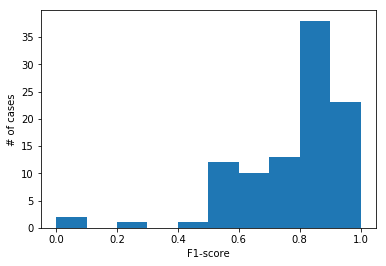

In [50]:
fig = plt.hist(f1scores)
plt.xlabel('F1-score')
plt.ylabel('# of cases')
plt.show()

In [51]:
bina = []
for i,r in enumerate(results):
    bina.append(gt[i] in r[:3])
print float(sum(bina))/len(bina)
        

0.84


In [52]:
sum(bina)

84

In [57]:
interventions1 = interventions

In [58]:
#Not really sure what is supposed to be happening at this cell, I assume we are working with interventions
# but I am not sure if these are inter_vectors or strings
Inters = []
for item in interventions1:
    inter = item.strip('{}').split('}{')
    inter = [i.split(':')[-1].strip().lower() for i in inter]
    Inters.append(inter)
interset = set()
for i in Inters:
    for j in i:
        interset.add(j)

AttributeError: 'list' object has no attribute 'strip'

In [59]:
interset

NameError: name 'interset' is not defined

In [60]:
protocol2inter = {
    'Medical - Chest Pain - Cardiac Suspected':['oxygen','cardiac monitor','12-lead ecg',\
                               'aspirin','midazolam (versed)','diazepam (valium)',\
                                'nitroglycerine','fentanyl','hospital contact','iv','normal saline'],
    'Medical - Abdominal Pain':['oxygen','cardiac monitor','12-lead ecg',\
                                'iv','normal saline','ondansetron (zofran)','hospital contact'],
    'General - Behavioral/Patient Restraint':['oxygen','midazolam (versed)','diazepam (valium)',\
                                              'hospital contact'],
    'General - Pain Control':['oxygen','cardiac monitor','12-lead ecg',\
                              'acetaminophen (tylenol)','iv','normal saline','fentanyl'],
    'Medical - Seizure':['nasopharyngeal airway insertio','oxygen',\
                        'iv','normal saline','midazolam (versed)','diazepam (valium)',\
                        'cardiac monitor','12-lead ecg','hospital contact'],
    'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway':['oxygen','capnography (1) first reading',\
                                                                        'capnography (2) second reading','capnography (3) final reading',\
                                                                       'assist ventilation (bvm)','endotracheal','duoneb','albuterol',
                                                                       'ipratropium (atrovent)','dexamethasone (decadron)','cpap',\
                                                                       'magnesium sulfate'],
    'Medical - Altered Mental Status':['oxygen','cardiac monitor','12-lead ecg','iv','normal saline',\
                                       'hospital contact'],
    'Medical - Diabetic - Hypoglycemia':['oxygen','cardiac monitor','12-lead ecg','iv','normal saline',\
                                       'hospital contact','dextrose 10%','dextrose 25%','dextrose 5% in 0.45% ns',\
                                        'dextrose 50%','oral glucose'],
    'Medical - Overdose/Poisoning - Opioid':['oxygen','cardiac monitor','12-lead ecg','iv','normal saline',\
                                       'hospital contact','naloxone (narcan)']
}

In [62]:
predict_inters = []
overlap_rate = []
for idx,item in enumerate(results):
    res = []
    for j in item[:3]:
        res += protocol2inter[j]
    res = set(res)
    predict_inters.append(res)
    ct = 0
    for i in Inters[idx]:
        if i in res:
            ct += 1
    overlap_rate.append(float(ct)/float(len(Inters[idx])))

    

IndexError: list index out of range

In [63]:
dfo = pd.DataFrame()
dfo['Narrative'] = narratives
dfo['Intervention'] = Inters
dfo['Score'] = scores
dfo['Ranking'] = [i[:3] for i in results]
dfo['Predict Intervention'] = predict_inters
dfo['Overlap Rate'] = overlap_rate
dfo.to_excel('OverlapEval_RAA2017.xlsx',index = False)

ValueError: Length of values does not match length of index

In [60]:
sum(overlap_rate)/len(overlap_rate)

0.864357527701289

In [12]:
dfr = DataFrame()
dfr['Narratives'] = narratives
dfr['Concepts'] = ['\n'.join(['(' + ','.join(i.strip('()').split(',')[:3]) + ')' for i in item]) for item in ConceptRes]
dfr.to_excel('ConceptExtracEval_ODEMSA_RAA_2.xlsx',index = False)


In [65]:
for i in range(len(narratives)):
    if not isinstance(narratives[i], basestring):
        print i

In [66]:
gt = df['Corrected Protocol']

KeyError: 'Corrected Protocol'

In [67]:
# rank and calculate ndcg
bina = []
ranks = []
ndcgs = []
for i,s in enumerate(results):   
    if gt[i] in pool:
        bina.append(gt[i] in s[:3])
        ranks.append(s[:3])
        if gt[i] not in s[:3]:
            print narratives[i]
            print ConceptRes[i]
            print gt[i]
            print s
            
        #ndcgs.append(nDCG(res[:3],gt[i],group,3))


A: Dispatched to the above address for an unconscious. Arrived on scene to find pt sitting on the floor of a cornor store. RFD and RPD both were on scene to assist with pt care.    C: Overdose    H: Pt was unresponsive when EMS first arrived on scene. When EMS moved pt to the back of the truck and placed and IV they pushed 1mg narcan. Pt became more responsive and pt started saying he wasnt going to the hosptial. Pt states he took too much of his oxycotin 5mg by accident he took 3 today. Pt states he feels better now that EMS gave him narcan. Pt states he didnt want to go to the hosptial because he has been in and out of the hospital. Pt agreed to let EMS take him to the hosptial. EMS had to place an NPA before he recieved the narcan because his airway was not secure on his own. Once pt woke up with the narcan NPA was removed.    A: Pt is A&Ox4 with a GCS of 15 after treatment before he was unconscious unresponsive. Airway is patent breathing normal and unlabored after treatment before

In [68]:
len(results)

100

In [69]:
sum(bina)

84

In [70]:
len(bina)

100

In [71]:
float(sum(bina))/len(bina)

0.84

In [72]:
float(sum(ndcgs)/len(ndcgs))

ZeroDivisionError: integer division or modulo by zero

In [73]:
# store results
dfr = DataFrame()
dfr['Narratives'] = t
dfr['Scores'] = [s for i,s in enumerate(scores) if gt[i] in pool]
dfr['Rank'] = ranks
dfr['GroundTruth'] = [g for g in gt if g in pool]
dfr['Correctness'] = bina

NameError: name 't' is not defined

In [74]:
dfr.to_excel('VecMethEval_ODEMSA_weighted&revised_RAA_2.xlsx',index = False)

In [35]:
FN2H = {
 '': 0,
 'aspirin': 1,
 'albuterol': 1,
 'bag valve mask ventilation': 3,
 'capnography': 1,
 'cardiac monitor': 1,
 'cpap': 3,
 'dexamethasone': 1,
 'dextrose': 3,
 'fentanyl': 0,
 'glucagon': 2,
 'ipratropium': 1,
 'midazolam': 3,
 'morphine sulfate': 0,
 'narcan': 3,
 'nasopharyngeal airway': 3,
 'nitroglycerine': 2,
 'normal saline': 0,
 'ondansetron': 0,
 'oral glucose': 1,
 'oxygen': 2,
 'physical restraint': 2,
 'transport': 0,
 'suction the oropharynx':2,
 'suction the nasopharynx':2
}

FP2H = {
 '': 0,
 'aspirin': 1,
 'bag valve mask ventilation': 1,
 'cardiac monitor': 0,
 'cpap': 2,
 'dexamethasone': 1,
 'dextrose': 1,
 'midazolam': 3,
 'narcan': 1,
 'nitroglycerin': 1,
 'normal saline': 1,
 'ondansetron': 0,
 'oral glucose': 1,
 'oxygen': 0,
 'physical restraint': 1,
 'transport': 0
}

In [36]:
res = pd.read_excel('./RAA_286_Feedback_Res_Modified.xlsx')

In [37]:
hs = []
for i in res['FN']:
    sc = [FN2H[it.strip().strip('\'')] for it in i.strip('[]').split(',')]
    hs.append(max(sc))
for idx,i in enumerate(res['FP']):
    sc = [FP2H[it.strip().strip('\'')] for it in i.strip('[]').split(',')]
    if max(sc) > hs[idx]:
        hs[idx] = max(sc)


In [38]:
print 'red:' + str(hs.count(3))
print 'orange:' + str(hs.count(2))
print 'yellow:' + str(hs.count(1))
print 'green:' + str(hs.count(0))

red:48
orange:49
yellow:122
green:67


In [40]:
48./286

0.16783216783216784

In [3]:
from tqdm import tqdm_notebook as tqdm
EKGset = set()
pred_int = []
EKGdic = {
     '':'',
     'AV_Block_1st_Deg':'AV_Block-1st_Degree',
     'AV_Block_1st_Degree':'AV_Block-1st_Degree',
     'AV_Block_1st_Degree,Sinus_Rhythm':'AV_Block-1st_Degree,Sinus_Rhythm',
     'AV_Block_2nd_Degree_Type_1':'AV_Block_2nd_Degree_Type_1',
     'Asystole':'Asystole',
     'Artifact':'Artifact',
     'Atrial_Fibrill':'Atrial_Fibrillation',
     'Atrial_Fibrillation':'Atrial_Fibrillation',
     'Atrial_Flutter':'Atrial_Flutter',
     'Juncti':'Junctional_Rhythm',
     'Junctiona':'Junctional_Rhythm',
     'Junctional':'Junctional_Rhythm',
     'Other_(Not_Listed)':'Other_(Not_Listed)',
     'P': 'Paced_Rhythm',
     'PEA':'Pulseless_Electrical_Activity',
     'Pac':'Paced_Rhythm',
     'Paced_Rhythm':'Paced_Rhythm',
     'Premature_Ventricular_Contractions,,Sinus_Rhythm':'Premature_Ventricular_Contractions,Sinus_Rhythm',
     'Premature_Ventricular_Contractions,Sinus_Rhythm':'Premature_Ventricular_Contractions,Sinus_Rhythm',
     'Right_Bundle_Branch_Block':'Right_Bundle_Branch_Block',
     'STEMI_Anterior_Ischemia':'STEMI_Anterior_Ischemia',
     'STEMI_Lateral_Ischemia':'STEMI_Lateral_Ischemia',
     'S':'Sinus_Rhythm',
     'Si':'Sinus_Rhythm',
     'Sin':'Sinus_Rhythm',
     'Sinu':'Sinus_Rhythm',
     'Sinus':'Sinus_Rhythm',
     'Sinus_':'Sinus_Rhythm',
     'Sinus_Arrhythmia':'Sinus_Arrhythmia',
     'Sinus_Arrhythmia,Sinus_Rhythm':'Sinus_Arrhythmia,Sinus_Rhythm',
     'Sinus_Arrhythmia,Sinus_Tachycardia':'Sinus_Arrhythmia,Sinus_Tachycardia',
     'Sinus_Bradycardia':'Sinus_Bradycardia',
     'Sinus_R':'Sinus_Rhythm',
     'Sinus_Rh':'Sinus_Rhythm',
     'Sinus_Rhy':'Sinus_Rhythm',
     'Sinus_Rhyth':'Sinus_Rhythm',
     'Sinus_Rhythm':'Sinus_Rhythm',
     'Sinus_T':'Sinus_Tachycardia',
     'Sinus_Tach':'Sinus_Tachycardia',
     'Sinus_Tachyc':'Sinus_Tachycardia',
     'Sinus_Tachycardi':'Sinus_Tachycardia',
     'Sinus_Tachycardia':'Sinus_Tachycardia',
     'Supravent':'Supraventricular_Tachycardia',
     'Supraventricular_Tachycardia':'Supraventricular_Tachycardia',
     'Ventricular_Fibrillation':'Ventricular_Fibrillation',
     'Ventricular_Tachycardia_(With_Pulse)':'Ventricular_Tachycardia'
}
# extract concept and calculate similarity
from ranking_func import rank
pool = set(['Medical - Abdominal Pain',
            'Medical - Altered Mental Status',
            'Medical - Seizure',
            'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
            'General - Behavioral/Patient Restraint',
            'Medical - Overdose/Poisoning - Opioid',
            'Medical - Diabetic - Hypoglycemia',
            'Medical - Chest Pain - Cardiac Suspected'])

def pre_tick_handler(behaviour_tree):
    blackboard = Blackboard()
    blackboard.tick_num += 1
results = []
scores = []
ConceptRes = []
for i,item in enumerate(tqdm(narratives)):
    vt = vitals[i].strip('{}').split('}{')
    vt = [it.split(':')[-1] for it in vt]
    for idx,it in enumerate(vt):
        if 'EKG-' in it:
            temp = it.split('EKG-')
            temp[1] = temp[1].replace(' ','_')
            temp[1] = temp[1].replace('-','_')
            vt[idx] = temp[0] + 'EKG-' + EKGdic[temp[1]]
            if len(temp[1]) > 0:
                EKGset.add(temp[1])
    vt = [ite for l in vt for ite in l.strip().split(' ')]
    for idx in xrange(len(vt)):
        if idx < len(vt) and '-' not in vt[idx]:
            vt.pop(idx)
    for idx,it in enumerate(vt):
        temp = it.split('-')
        vt[idx] = (temp[0],temp[1])
    blackboard = Blackboard()
    blackboard.text = item
    root = py_trees.composites.Sequence("Root_1")
    IG = be.IG(slist = '/Users/sileshu/Downloads/Archive/WithoutUnigram/50candidateConcepts_Med.txt', \
                                 inC = vt)
    TC = be.TextCollection()
    V = be.Vectorize()
    PS = be.ProtocolSelector()
    root.add_children([TC,IG,V,PS,be.protocols])
    behaviour_tree = py_trees.trees.BehaviourTree(root)
    behaviour_tree.add_pre_tick_handler(pre_tick_handler)
    behaviour_tree.setup(15)
    behaviour_tree.tick_tock(
            sleep_ms=50,
            number_of_iterations=1,
            pre_tick_handler=None,
       post_tick_handler=None
        )
    scores.append(blackboard.ranking)
   # ConceptRes.append(blackboard.ConcLog)
    results.append(blackboard.candi)
    res = []
    for key in blackboard.feedback:
        if blackboard.feedback[key] > 0.1:
            res.append(key)
    pred_int.append(res)    

/Users/sileshu/anaconda/lib/python2.7/site-packages/scipy/spatial/distance.py:644: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
INFO:CoreNLP_PyWrapper:Subprocess seems to be stopped, exit code 1
INFO:CoreNLP_PyWrapper:mode given as 'parse' so setting annotators: tokenize, ssplit, pos, lemma, parse
INFO:CoreNLP_PyWrapper:Starting java subprocess, and waiting for signal it's ready, with command: exec java -Xmx4g -XX:ParallelGCThreads=1 -cp '/Users/sileshu/anaconda/lib/python2.7/site-packages/stanford_corenlp_pywrapper/lib/*:/Users/sileshu/Downloads/stanford-corenlp-full-2018-10-05/*'      corenlp.SocketServer --outpipe /tmp/corenlp_pywrap_pipe_pypid=5910_time=1544840653.0  --configdict '{"annotators":"tokenize, ssplit, pos, lemma, parse"}'
INFO:CoreNLP_PyWrapper:Successful ping. The server has started.
INFO:CoreNLP_PyWrapper:Subprocess is ready.
INFO:CoreNLP_PyWrapper:Subprocess seems to be stopped, exit code 1
INFO:CoreNLP_PyWrapper:mo

In [17]:
gt

[u'Medical - Overdose/Poisoning - Opioid',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'Medical - Abdominal Pain',
 u'General - Behavioral/Patient Restraint',
 u'Medical - Seizure',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Altered Mental Status',
 u'Medical - Abdominal Pain',
 u'Medical - Altered Mental Status',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Altered Mental Status',
 u'Medical - Seizure',
 u'Medical - Overdose/Poisoning - Opioid',
 u'Medical - Abdominal Pain',
 u'Medical - Altered Mental Status',
 u'Medical - Altered Mental Status',
 u'Medical - Respiratory Distress/Asthma/COPD/Croup/Reactive Airway',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Chest Pain - Cardiac Suspected',
 u'Medical - Overdose/Poisoning - Opioi

In [18]:
interventions

[['bag valve mask ventilation', 'normal saline', 'cardiac monitor', 'narcan'],
 ['cardiac monitor',
  'cardiac monitor',
  'albuterol',
  'ipratropium',
  'oxygen',
  'transport'],
 ['cardiac monitor', 'transport'],
 ['cardiac monitor', 'normal saline', 'physical restraint', 'transport'],
 ['cardiac monitor', 'transport'],
 ['cardiac monitor', 'cardiac monitor', 'transport'],
 ['cardiac monitor', 'cardiac monitor', 'normal saline', 'transport'],
 ['cardiac monitor', 'cardiac monitor', 'transport'],
 ['cardiac monitor', 'transport', 'normal saline'],
 ['cardiac monitor',
  'normal saline',
  'normal saline',
  'ondansetron',
  'cardiac monitor',
  'transport'],
 ['oxygen', 'normal saline', 'cardiac monitor', 'transport'],
 ['normal saline', 'cardiac monitor', 'cardiac monitor', 'transport'],
 ['cardiac monitor',
  'cardiac monitor',
  'normal saline',
  'normal saline',
  'cardiac monitor',
  'transport'],
 ['cardiac monitor',
  'cardiac monitor',
  'normal saline',
  'ondansetron',
  '

In [11]:
TP = 0.
FP = 0.
FN = 0.
fpst = dict()
fnst = dict()
fps = []
fns = []

precisions = []
recalls = []
f1scores = []
for i,item in enumerate(pred_int):
    TP = 0.
    FP = 0.
    FN = 0.
    fp = []
    fn = []
    for m in item:
        if m in interventions[i]:
            TP += 1
        else:
            if m in fpst:
                fpst[m] += 1
            else:
                fpst[m] = 1
            FP += 1
            fp.append(m)
    for n in interventions[i]:
        if n not in pred_int[i]:
            if n in fnst:
                fnst[n] += 1
            else:
                fnst[n] = 1
            FN += 1
            fn.append(n)
    fps.append(fp)
    fns.append(fn)
    if TP == 0 and FP == 0:
        recalls.append(TP / (TP + FN))
        precisions.append(0.)
        f1scores.append(2 * TP / (2 * TP + FN + FP))
        continue
    recalls.append(TP / (TP + FN))
    precisions.append(TP / (TP + FP))
    f1scores.append(2 * TP / (2 * TP + FN + FP))

In [12]:
ct = 0
fnc = 0
fpc = 0
for i in range(len(fns)):
    if len(fns[i]) == 0 and len(fps[i]) == 0:
        ct += 1
    if len(fns[i]) == 0:
        fpc += 1
    if len(fps[i]) == 0:
        fnc += 1
        
ct,fnc,fpc

(36, 111, 113)

In [13]:
print 'M-precision:' + '%.3f'%(sum(precisions)/len(precisions))
print 'M-recall:' + '%.3f'%(sum(recalls)/len(recalls))
print 'M-F1-score:' + '%.3f'%(sum(f1scores)/len(f1scores))

M-precision:0.740
M-recall:0.726
M-F1-score:0.706


In [14]:
bina = []
for i,r in enumerate(results):
    bina.append(gt[i] in r[:3])
print float(sum(bina))/len(bina)

0.657342657343


In [15]:
df['FN'] = fns
df['FP'] = fps

In [16]:
df.to_excel('RAA_286_50candidateConcepts_Med_wU_RAA_2.xlsx',index = False)

In [14]:
res = pd.read_excel('./RAA_286_50candidateConcepts_Med_wU_RAA_2.xlsx')

In [15]:
FN2H = {
 '': 0,
 'aspirin': 1,
 'albuterol': 1,
 'bag valve mask ventilation': 3,
 'capnography': 1,
 'cardiac monitor': 1,
 'cpap': 3,
 'dexamethasone': 1,
 'dextrose': 3,
 'fentanyl': 0,
 'glucagon': 2,
 'ipratropium': 1,
 'midazolam': 3,
 'morphine sulfate': 0,
 'narcan': 3,
 'nasopharyngeal airway': 3,
 'nitroglycerine': 2,
 'normal saline': 0,
 'ondansetron': 0,
 'oral glucose': 1,
 'oxygen': 2,
 'physical restraint': 2,
 'transport': 0,
 'suction the oropharynx':2,
 'suction the nasopharynx':2
}

FP2H = {
 '': 0,
 'aspirin': 1,
 'bag valve mask ventilation': 1,
 'cardiac monitor': 0,
 'cpap': 2,
 'dexamethasone': 1,
 'dextrose': 1,
 'midazolam': 3,
 'narcan': 1,
 'nitroglycerin': 1,
 'normal saline': 1,
 'ondansetron': 0,
 'oral glucose': 1,
 'oxygen': 0,
 'physical restraint': 1,
 'transport': 0
}

hs = []
for i in res['FN']:
    sc = [FN2H[it.strip().strip('\'')] for it in i.strip('[]').split(',')]
    hs.append(max(sc))
for idx,i in enumerate(res['FP']):
    sc = [FP2H[it.strip().strip('\'')] for it in i.strip('[]').split(',')]
    if max(sc) > hs[idx]:
        hs[idx] = max(sc)
        
print 'red:' + str(hs.count(3))
print 'orange:' + str(hs.count(2))
print 'yellow:' + str(hs.count(1))
print 'green:' + str(hs.count(0))

red:49
orange:40
yellow:145
green:52
